In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# generate some data
mu_0 = -5
sigma_0 = 3
mu_1 = 3
sigma_1 = 2

n_clips = 5000
n_pos = 200

# generate data
scores = np.zeros(n_clips)
labels = np.zeros(n_clips)
scores[:n_pos] = np.random.normal(mu_1, sigma_1, n_pos)
labels[:n_pos] = 1
scores[n_pos:] = np.random.normal(mu_0, sigma_0, n_clips - n_pos)
labels[n_pos:] = 0

# make a labeling weighting. Try 1/rank
df = pd.DataFrame({'score': scores, 'label': labels})
df = df.sort_values("score", ascending=False)
df["weighting"] = 1/(1 + np.arange(len(df)))

# shuffle them just to remove any ordering
df = df.sample(frac=1)

# ensure labels are integers
df["label"] = df["label"].astype(int)

n_labeled = 25

# sample according to the weighting
labeled = df.sample(n_labeled, weights="weighting")
unlabeled = df.drop(labeled.index)

# normalize the labeled weights
labeled["weighting"] = labeled["weighting"] / labeled["weighting"].sum()

# make the data dictionary
data = {'N_labeled': len(labeled), 
        'N_unlabeled': len(unlabeled), 
        'scores_labeled': labeled['score'].values, 
        'scores_unlabeled': unlabeled['score'].values,
        'sampling_weight': labeled["weighting"].values,
        'labels': labeled["label"].values}

# make the data


Number of positives in labeled data: 11
proportion of positives in labeled data: 0.44
proportion of positives in all data: 0.04


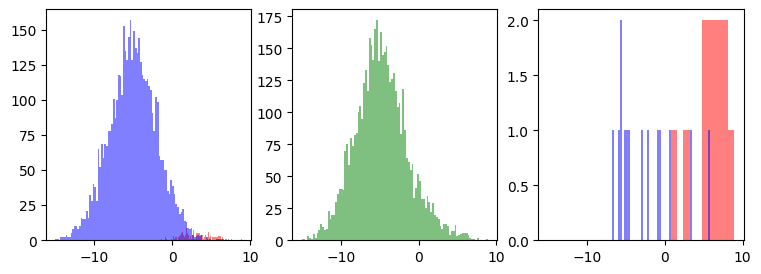

In [75]:
# plot the histogram of scores
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 3, figsize=(9, 3), sharex=True)
pos = df[df['label'] == 1]
neg = df[df['label'] == 0]
ax[0].hist(pos['score'], bins=100, alpha=0.5, label='pos', color='red')
ax[0].hist(neg['score'], bins=100, alpha=0.5, label='neg', color='blue')
ax[1].hist(df['score'], bins=100, alpha=0.5, label='all', color='green')
ax[2].hist(labeled[labeled["label"] ==1]['score'], bins=10, alpha=0.5, label='labeled', color='red')
ax[2].hist(labeled[labeled["label"] ==0]['score'], bins=50, alpha=0.5, label='unlabeled', color='blue')
print(f"Number of positives in labeled data: {np.sum(labeled['label'])}")
print(f"proportion of positives in labeled data: {np.mean(labeled['label'])}")
print(f"proportion of positives in all data: {np.mean(df['label'])}")

In [76]:
#import cmdstanpy and use the stan model
import cmdstanpy
file = "weighted_sample_gmm.stan"
model = cmdstanpy.CmdStanModel(stan_file=file)

In [77]:
# fit the model
fit = model.sample(data=data, chains=4, iter_warmup=250, iter_sampling=250)

17:00:37 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17:00:41 - cmdstanpy - INFO - CmdStan done processing.
17:00:41 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'weighted_sample_gmm.stan', line 27, column 12 to line 29, column 86)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'weighted_sample_gmm.stan', line 27, column 12 to line 29, column 86)
Consider re-running with show_console=True if the above output is unclear!


In [78]:
samples = fit.draws_pd()
# summarize the results
summary = fit.summary()

In [79]:
summary

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,-18371.500000,0.069859,1.580150,-18374.500000,-18371.200000,-18369.600000,511.627000,103.673000,1.002860
mu[1],-5.102240,0.001108,0.033540,-5.157540,-5.102620,-5.047770,915.537000,185.519000,0.998878
mu[2],2.192180,0.005596,0.157420,1.931640,2.195140,2.471920,791.249000,160.334000,1.000360
sigma[1],2.586380,0.000830,0.025378,2.541910,2.587250,2.626970,935.720000,189.609000,0.998030
sigma[2],1.994330,0.003196,0.099420,1.838160,1.991890,2.169500,967.505000,196.050000,0.998922
theta,0.050596,0.000128,0.003827,0.044513,0.050468,0.057093,887.255050,179.788257,0.999793
n_pos_pred,253.559000,0.766707,24.245378,213.000000,253.000000,293.000000,999.999001,202.634043,1.001128
